In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

C:\Users\ayana\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and a mapping to/from integers
charset = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(charset)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many letter you will take to predict the next one 
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [7]:
# Embeddings
C = torch.randn((27,2))

In [8]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [11]:
h.shape

torch.Size([32, 100])

In [12]:
h

tensor([[-0.9586,  0.9764, -0.5734,  ...,  0.8650, -0.3421,  0.4239],
        [-0.9873, -0.7045,  0.8183,  ...,  0.1930, -0.9419,  0.4022],
        [ 0.9819, -0.9989, -1.0000,  ..., -0.9443, -0.7471,  0.9731],
        ...,
        [ 0.3592, -0.8267, -0.9977,  ..., -0.9988, -0.9835, -0.9953],
        [ 0.3762,  0.8692,  0.4717,  ..., -0.8381, -0.8468, -0.9769],
        [ 0.4550,  0.3216, -1.0000,  ..., -0.2051,  0.7411,  0.9509]])

In [13]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2 
logits.shape

torch.Size([32, 27])

In [15]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [16]:
-probs[torch.arange(32), Y].log().mean()

tensor(15.9415)

In [17]:
## ============= PUTING EVERYTHING TOGETHER ===================
# build the dataset 

block_size = 3 # context length: how many letter you will take to predict the next one 
X, Y = [], []

for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [39]:
# Random Initialization of weights and biases
g = torch.Generator().manual_seed(220)
C = torch.randn((27,2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [40]:
sum(p.nelement() for p in parameters) # number of parameters in total 

3481

In [41]:
# Forward Pass
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2 
# counts = logits.exp() 
# probs = counts / counts.sum(1, keepdims=True) 
# loss = -probs[torch.arange(probs.shape[0]), Y].log().mean() 
loss = F.cross_entropy(logits, Y)
loss

tensor(17.8829, grad_fn=<NllLossBackward0>)

In [42]:
# backward pass 
W1.grad = None 
b1.grad = None 
W2.grad = None 
b2.grad = None 
C.grad = None 
loss.backward()

In [22]:
# Update
alpha = 0.1
W1.data += -alpha*W1.grad 
W2.data += -alpha*W2.grad 
b1.data += -alpha*b1.grad 
b2.data += -alpha*b2.grad 
C.data += -alpha*C.grad 


In [23]:
## ============== TRAINING ===================

In [76]:
# Building data set with Train dev test split 
def build_dataset(words):
    block_size = 3 # context length: how many letter you will take to predict the next one 
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])    

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [123]:
# Random Initialization of weights and biases
g = torch.Generator().manual_seed(220)
C = torch.randn((27,10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [124]:
sum(p.nelement() for p in parameters) 

11897

In [125]:
lri = []
lossi = []
stepi =[]

In [130]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01
    
    for p in parameters:
        p.data += -lr*p.grad

    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

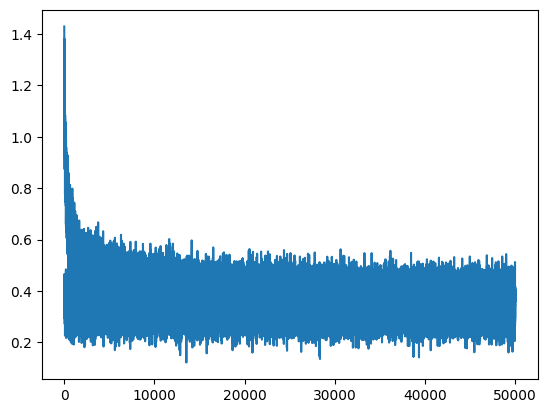

In [131]:
plt.plot(stepi, lossi)

In [132]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1937, grad_fn=<NllLossBackward0>)

In [133]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1647, grad_fn=<NllLossBackward0>)

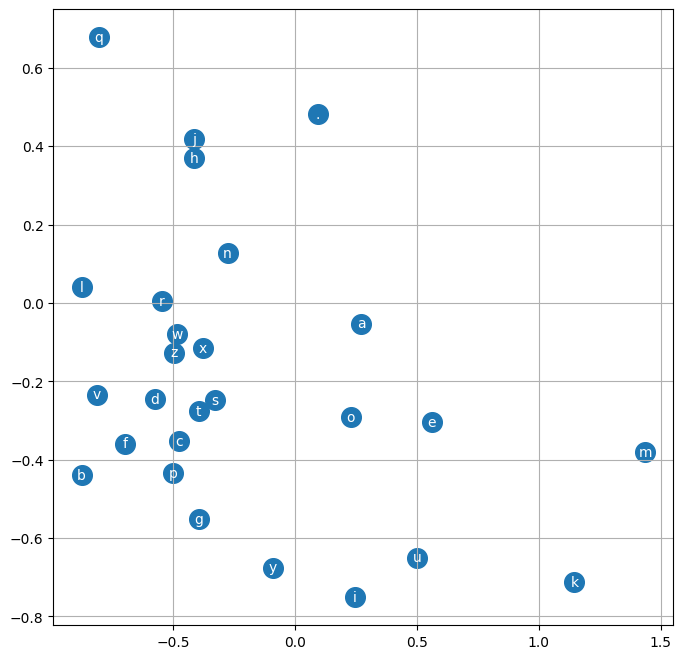

In [113]:
# # visualizing embeddings 
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:, 1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

# plt.grid('minor')

In [136]:
# sample from the model
g = torch.Generator().manual_seed(220 + 10)
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2  
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

jiannaelia.
lor.
graggistiviah.
briya.
tato.
oorandreyson.
falari.
jovelei.
rafyeld.
temanden.
bran.
harrominandriclee.
dam.
chila.
madellon.
gamero.
saniel.
kayii.
dar.
fond.
